In [64]:
pip install spacy

Note: you may need to restart the kernel to use updated packages.


In [65]:
!python -m spacy download en_core_web_sm 

  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.4.1/en_core_web_sm-3.4.1-py3-none-any.whl (12.8 MB)
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [66]:
# -*- coding: utf-8 -*-
import re
import string
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from pygam import LogisticGAM

In [67]:
import spacy
from nltk import tokenize 
from nltk.tokenize import TweetTokenizer
from collections import Counter
nlp = spacy.load('en_core_web_sm')

In [68]:
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\pengq\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [69]:
def remove_stopwords(df):
    #tweets = data['cleansed_text']
    fragments = df
    nlp = spacy.load('en_core_web_sm')

    # Can manually add words which you think might not be helpful
    wordsToRemove = set()
    #wordsToRemove.add('help')
    
    # Create array of clean tweets, lower case, no stop words or small words, no hyperlinks
    cleanedFragments = []
    tknzr = TweetTokenizer()
    for t in fragments: 
        cleaned = [word for word in tknzr.tokenize(t.lower()) 
                   if word not in nlp.Defaults.stop_words 
                   if word not in wordsToRemove
                   and len(word) > 2
                   and 'http://' not in word
                   and 'https://' not in word
                  ] 
        cleanedFragments.append(' '.join(cleaned))

    return cleanedFragments

In [70]:
def lemmatization(cleanedFragment):
    
    tknzr = TweetTokenizer()
    wnl = WordNetLemmatizer()

    lemmaFragment = []
    for t in cleanedFragment: 
        cleaned = [wnl.lemmatize(word) for word in tknzr.tokenize(t)] 
        lemmaFragment.append(' '.join(cleaned))

    #lemmaTokens = []
    #for l in lemmaFragment:
    #    lemmaTokens.append(tknzr.tokenize(l))
            
    return lemmaFragment

In [71]:
class Data_Processor:
    def __init__(self, df, words_indexes=list(), chars_indexes=list(), is_unuseful=None):
        self.df = df
        self.words_indexes = words_indexes
        self.chars_indexes = chars_indexes
        self.all_fragments = [row for row in df['processed_text']]
        self.char_counts_all = dict()
        self.word_counts_all = dict()
        if is_unuseful is not None:
            self.unuseful_fragments = [row for row in df[is_unuseful == True]['processed_text']]
            self.char_counts_unuseful = dict()
            self.word_counts_unuseful = dict()
            self.useful_fragments = [row for row in df[is_unuseful == False]['processed_text']]
            self.char_counts_useful = dict()
            self.word_counts_useful = dict()

    # count each punctuation in the fragments
    @staticmethod
    def count_chars(fragment, char_counts):
        for char in fragment:
            if char in string.punctuation:
                if char in char_counts:
                    char_counts[char] += 1
                else:
                    char_counts[char] = 1
        return char_counts

    # count each word in the fragments
    @staticmethod
    def count_words(fragment, word_counts):
        words = re.split(r'[!"#$%&\'()*+,-./:;<=>?@[\]^_`{|}~\s\n]+', fragment.lower())  # r'[.,?!:;&-\'|<>/\s\n]+'
        for word in words:
            if word:
                if word in word_counts:
                    word_counts[word] += 1
                else:
                    word_counts[word] = 1
        return word_counts

    def summary(self):
        # count chars and words for  whole fragments
        for fragment in self.all_fragments:
            self.char_counts_all = self.count_chars(fragment, self.char_counts_all)
            self.word_counts_all = self.count_words(fragment, self.word_counts_all)

        # count chars and words for unuseful fragments if exists
        if self.unuseful_fragments is not None:
            for fragment in self.unuseful_fragments:
                self.char_counts_unuseful = self.count_chars(fragment, self.char_counts_unuseful)
                self.word_counts_unuseful = self.count_words(fragment, self.word_counts_unuseful)
            for fragment in self.useful_fragments:
                self.char_counts_useful = self.count_chars(fragment, self.char_counts_useful)
                self.word_counts_useful = self.count_words(fragment, self.word_counts_useful)

    # show the figures of frequency
    def plot(self, char_counts, word_counts, char_min_freq=0, word_min_freq=0):
        sorted_chars = {k: v for k, v in sorted(char_counts.items(), key=lambda item: item[1]) if
                        v > char_min_freq}
        print(sorted_chars)
        plt.figure(1)
        plt.barh(list(sorted_chars.keys()), list(sorted_chars.values()))
        plt.show()

        sorted_words = {k: v for k, v in sorted(word_counts.items(), key=lambda item: item[1]) if
                        v > word_min_freq}
        print(sorted_words)
        plt.figure(2)
        plt.barh(list(sorted_words.keys()), list(sorted_words.values()))
        plt.show()

    def select_words(self, word_num):
        # sort dicts
        sorted_words_useful = {k: v for k, v in sorted(self.word_counts_all.items(), key=lambda item: item[1])}
        sorted_words_unuseful = {k: v for k, v in sorted(self.word_counts_unuseful.items(), key=lambda item: item[1])}

        # get the keys for dict_all
        word_keys_useful = list(sorted_words_useful.keys())
        word_keys_useful.reverse()

        # get the keys for dict_unuseful
        word_keys_unuseful = list(sorted_words_unuseful.keys())
        word_keys_unuseful.reverse()

        # select words indexes for model
        for i in range(word_num):
            if word_keys_unuseful[i] != word_keys_useful[i]:
                self.words_indexes.append(word_keys_unuseful[i])


    # transform original dataframe to frequency dataframe
    def data_processing(self):
        # define a dict to store columns for new dataframe
        newdf_dict = dict()
        # define word_freq and add them into the newdf_dict
        for word in self.words_indexes:
            newdf_dict["word_freq_{}".format(word)] = list()

        # define word_freq and add them into the newdf_dict
        for char in self.chars_indexes:
            newdf_dict["char_freq_{}".format(char)] = list()

        # define other variables
        newdf_dict["capital_run_length_average"] = list()
        newdf_dict["capital_run_length_longest"] = list()
        newdf_dict["capital_run_length_total"] = list()
        newdf_dict["fragment_length"] = list()

        for fragment in self.all_fragments:
            char_counts_each = dict()
            word_counts_each = dict()
            char_counts_each = self.count_chars(fragment, char_counts_each)
            word_counts_each = self.count_words(fragment, word_counts_each)

            # word_freq_WORD
            # = percentage of words in the e-mail that match WORD,
            # i.e. 100 * (number of times the WORD appears in the e-mail) / total number of words in e-mail.
            for word in self.words_indexes:
                newdf_dict["word_freq_{}".format(word)].append((100 * word_counts_each[word] / sum(
                    word_counts_each.values()) if word in word_counts_each.keys() else 0))

            # char_freq_CHAR
            # = percentage of characters in the e-mail that match CHAR,
            # i.e. 100 * (number of the CHAR appears in the e-mail) / total characters in e-mail
            for char in self.chars_indexes:
                newdf_dict["char_freq_{}".format(char)].append(100 * char_counts_each[char] / sum(
                    char_counts_each.values()) if char in char_counts_each.keys() else 0)

            # capital_run_length_average
            # = average length of uninterrupted sequences of capital letters
            capital_runs = re.findall(r"[A-Z]+", fragment)
            capital_runs_length = [len(string) for string in capital_runs]
            newdf_dict["capital_run_length_average"].append(sum(capital_runs_length) / len(capital_runs_length) \
                                                                if len(capital_runs_length) != 0 else 0)

            # capital_run_length_longest
            # = length of the longest uninterrupted sequence of capital letters
            newdf_dict["capital_run_length_longest"].append(
                len(max(capital_runs, key=len)) if len(capital_runs_length) != 0 else 0)

            # capital_run_length_total
            # = sum of length of uninterrupted sequences of capital letters
            # i.e. = total number of capital letters
            newdf_dict["capital_run_length_total"].append(sum(capital_runs_length))

            # fragment_length
            # = length of a fragment
            newdf_dict["fragment_length"].append(len(fragment))

        # define new dataframe
        newdf = pd.DataFrame.from_dict(newdf_dict)
        newdf.to_csv("newdf.csv")
        return newdf

    @staticmethod
    def log_transform(newdf):
        newdf_log = np.log(0.1 + newdf)
        newdf.to_csv("newdf_log.csv")
        return newdf_log

In [72]:
class Logistic_Regression:
    def __int__(self):
        print("Building a GAM model")

    @staticmethod
    def split_train_test(df, is_unuseful):
        # split the data into training and test
        X_train, X_test, y_train, y_test = train_test_split(df, is_unuseful, test_size=0.33,
                                                            random_state=1)
        return X_train, X_test, y_train, y_test

    @staticmethod
    def training(X_train, y_train):
        # fit a GAM model
        gam = LogisticGAM().fit(X_train, y_train)

        return gam

    @staticmethod
    def summary(gam):
        # get the model summary
        gam.summary()

    @staticmethod
    def predict(gam, X_test, y_test):
        predictions = gam.predict(X_test)
        print("Accuracy: {} ".format(accuracy_score(y_test, predictions)))
        #probas = gam.predict_proba(X_test)
        #print("Log Loss: {} ".format(log_loss(y_test, probas)))
        return predictions

In [73]:
# import the dataset
df = pd.read_excel("Data/Labelled_data_processed.xlsx")
print(df.describe())

# summary of initial dataset
print(df['is_unuseful'].value_counts())

# drop duplicates
df = df.drop_duplicates(subset="processed_text") 
df = df[df['processed_text'].notna()]

# define the label column
is_unuseful = df['is_unuseful']

                                    cleansed_text  \
count                                         980   
unique                                        910   
top     What do you appreciate most about Canvas?   
freq                                           16   

                            created_at class is_unuseful  \
count                              980   980         980   
unique                             933     2           2   
top     2021-12-08 15:21:30.000000 UTC  chat       False   
freq                                 5   803         761   

                                   processed_text  
count                                         965  
unique                                        879  
top     What do you appreciate most about Canvas?  
freq                                           16  
False    761
True     219
Name: is_unuseful, dtype: int64


In [74]:
# remove stopwords
df['processed_text'] = remove_stopwords(df['processed_text'])
df

,cleansed_text,created_at,class,is_unuseful,processed_text
0,Help Alyssa understand how they’re doing:,2022-08-26 15:37:28.000000 UTC,chat,True,help alyssa understand
1,Hi there - Just an update that I’m closing out...,2022-08-26 15:37:15.000000 UTC,chat,True,update closing conversation didn hear feel fre...
2,Case #: 04972861\n\n\n\nYour request has been ...,2014-06-06 13:28:15.000000 UTC,chat,True,request received field services contacted soon...
3,"Hi Wayne,\n\n\n\nUnfortunately, that is not a ...",2015-11-10 18:32:39.000000 UTC,chat,False,unfortunately field populated report header fo...
4,Case #: 15443630\n\n\n\nYour request has been ...,2020-03-11 18:12:22.000000 UTC,chat,True,request received field services contacted soon...
...,...,...,...,...,...
975,Help Jeremy understand how they’re doing:,2020-04-26 14:06:35.000000 UTC,chat,True,help jeremy understand
976,"Hi Alan,\n\nThank you for clarifying. Are you...",2020-04-26 13:55:47.000000 UTC,chat,False,thank clarifying able send exp utility bill se...
977,"Hi Alan,\n\nAppreciate the diligent response. ...",2020-04-26 15:38:45.000000 UTC,chat,False,appreciate diligent response reviewed document...
978,Hi Alan\n\n\n\nThank you for your interest in ...,2020-04-26 02:09:06.000000 UTC,chat,False,thank interest zayzoon reviewing noticed sligh...


In [75]:
df['processed_text'] = lemmatization(df['processed_text'])
df

,cleansed_text,created_at,class,is_unuseful,processed_text
0,Help Alyssa understand how they’re doing:,2022-08-26 15:37:28.000000 UTC,chat,True,help alyssa understand
1,Hi there - Just an update that I’m closing out...,2022-08-26 15:37:15.000000 UTC,chat,True,update closing conversation didn hear feel fre...
2,Case #: 04972861\n\n\n\nYour request has been ...,2014-06-06 13:28:15.000000 UTC,chat,True,request received field service contacted soon ...
3,"Hi Wayne,\n\n\n\nUnfortunately, that is not a ...",2015-11-10 18:32:39.000000 UTC,chat,False,unfortunately field populated report header fo...
4,Case #: 15443630\n\n\n\nYour request has been ...,2020-03-11 18:12:22.000000 UTC,chat,True,request received field service contacted soon ...
...,...,...,...,...,...
975,Help Jeremy understand how they’re doing:,2020-04-26 14:06:35.000000 UTC,chat,True,help jeremy understand
976,"Hi Alan,\n\nThank you for clarifying. Are you...",2020-04-26 13:55:47.000000 UTC,chat,False,thank clarifying able send exp utility bill se...
977,"Hi Alan,\n\nAppreciate the diligent response. ...",2020-04-26 15:38:45.000000 UTC,chat,False,appreciate diligent response reviewed document...
978,Hi Alan\n\n\n\nThank you for your interest in ...,2020-04-26 02:09:06.000000 UTC,chat,False,thank interest zayzoon reviewing noticed sligh...


In [76]:
# define the words/chars indexes
chars_indexes = [':', '-', '*', ';', '\'', '!', '@', '#', '$']
dp = Data_Processor(df, words_indexes=list(), chars_indexes=chars_indexes, is_unuseful=is_unuseful)

In [77]:
# get the words/chars count for all fragments and unuseful fragments
dp.summary()

{'+': 4, '=': 5, ')': 6, '(': 8, ',': 9, '_': 19, ':': 36, '@': 69, '#': 85, '<': 111, '>': 113, '/': 122, "'": 235, '.': 266, '-': 778}


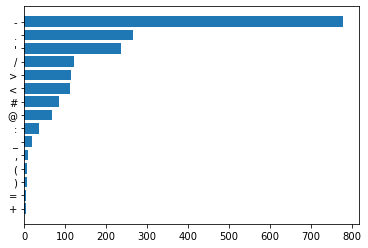

{'account': 94, 'information': 94, 'time': 96, 'case': 99, 'concur': 102, 'let': 106, 'mso': 107, 'message': 108, 'help': 113, 'know': 119, 'report': 122, 'important': 142, 'expense': 143, 'email': 170, 'thank': 196}


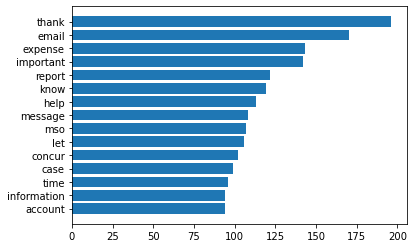

{'_': 2, '(': 6, ')': 7, '<': 8, ':': 9, '>': 9, '@': 17, '/': 24, '#': 37, "'": 83, '-': 211, '.': 350}


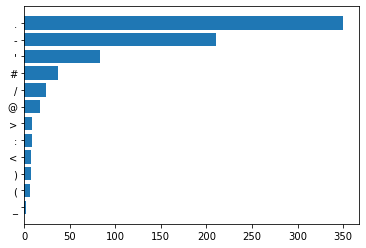

{'question': 31, 'contact': 31, 'support': 32, 'service': 33, 'respond': 34, 'office': 36, 'new': 37, 'recipient': 38, 'information': 39, '10': 41, 'case': 46, 'help': 47, 'request': 53, 'com': 54, 'e': 59, 'mail': 61, 'thank': 64, 'received': 75, 'message': 79, 'email': 111}


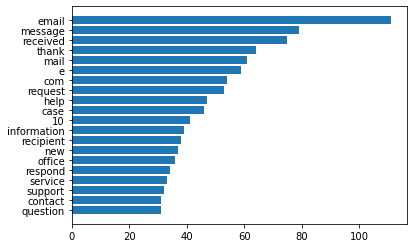

In [78]:
# show the boxplots of frequency for useful fragments and unuseful fragments
#, char_min_freq=300, word_min_freq=100
dp.plot(dp.char_counts_useful, dp.word_counts_useful, char_min_freq=0, word_min_freq=90)
dp.plot(dp.char_counts_unuseful, dp.word_counts_unuseful, char_min_freq=0, word_min_freq=30)

In [79]:
# choose words indexes
dp.select_words(word_num=55)
print("Words Indexes: {} ".format(dp.words_indexes))
print("Chars Indexes: {} ".format(chars_indexes))

Words Indexes: ['message', 'received', 'thank', 'mail', 'e', 'com', 'request', 'help', 'case', '10', 'information', 'recipient', 'new', 'office', 'respond', 'service', 'support', 'contact', 'question', 'chatbooks', 'hour', 'know', 'rural', 's', '2', 'address', 'close', 'reply', 'need', 'let', 'day', 'account', 'soon', '9', '237', 't', 'monday', 'assistance', 'send', 'understand', 'font', 'time', 'receive', 'hire', 'error', 'work', '1', 'friday', 'team', '66', 'great', 'immediately', 'i', 'assigned'] 
Chars Indexes: [':', '-', '*', ';', "'", '!', '@', '#', '$'] 


In [80]:
# data processing and get the new dataframe
newdf = dp.data_processing()
newdf_log = dp.log_transform(newdf)

In [81]:
# MODEL PART
lg_model = Logistic_Regression()
# split training and test data set
X_train, X_test, y_train, y_test = lg_model.split_train_test(newdf_log, is_unuseful)

# training the model
gam = lg_model.training(X_train, y_train)

did not converge


In [82]:
# summary of the model
lg_model.summary(gam)

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     30.8902
Link Function:                        LogitLink Log Likelihood:                                  -211.6988
Number of Samples:                          588 AIC:                                               485.178
                                                AICc:                                              488.957
                                                UBRE:                                               2.8672
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.3266
Feature Function                  Lam

C:\Users\pengq\AppData\Local\Temp\ipykernel_14360\444524877.py:22: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


In [83]:
# get the training accuracy
y_pred_train = lg_model.predict(gam, X_train, y_train)
print("Training Accuracy: {} ".format(gam.accuracy(X_train, y_train)))

Training Accuracy: 0.8605442176870748 


In [84]:
# prediction
y_pred_test = lg_model.predict(gam, X_test, y_test)

Accuracy: 0.8605442176870748 
Accuracy: 0.865979381443299 


In [85]:
cm_train = confusion_matrix(y_train, y_pred_train)
tn, fp, fn, tp = cm_train.ravel()
sensitive = tp/(tp + fn)
specificity = tn / (tn+fp)
cr_train = classification_report(y_train, y_pred_train)
print(cm_train)
print(cr_train)
print(sensitive)
print(specificity)

[[451   4]
 [ 78  55]]
              precision    recall  f1-score   support

       False       0.85      0.99      0.92       455
        True       0.93      0.41      0.57       133

    accuracy                           0.86       588
   macro avg       0.89      0.70      0.74       588
weighted avg       0.87      0.86      0.84       588

0.41353383458646614
0.9912087912087912


In [86]:
cm_test = confusion_matrix(y_test, y_pred_test)
cr_test = classification_report(y_test, y_pred_test)
tn, fp, fn, tp = cm_test.ravel()
sensitive = tp/(tp + fn)
specificity = tn / (tn+fp)
print(cm_test)
print(cr_test)
print(sensitive)
print(specificity)

[[238   1]
 [ 38  14]]
              precision    recall  f1-score   support

       False       0.86      1.00      0.92       239
        True       0.93      0.27      0.42        52

    accuracy                           0.87       291
   macro avg       0.90      0.63      0.67       291
weighted avg       0.88      0.87      0.83       291

0.2692307692307692
0.99581589958159


In [87]:
df_ori = pd.read_excel("Data/Labeled Data.xlsx")
df_test = df_ori.iloc[y_test.index]
df_test['pred'] = y_pred_test

test_specificity = pd.DataFrame([row for index, row in df_test.iterrows() if row['is_unuseful'] == False and row['pred'] == True])
test_specificity

test_specificity.to_csv("test_specificity.csv")

C:\Users\pengq\AppData\Local\Temp\ipykernel_14360\2337869232.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['pred'] = y_pred_test


<Figure size 432x288 with 0 Axes>

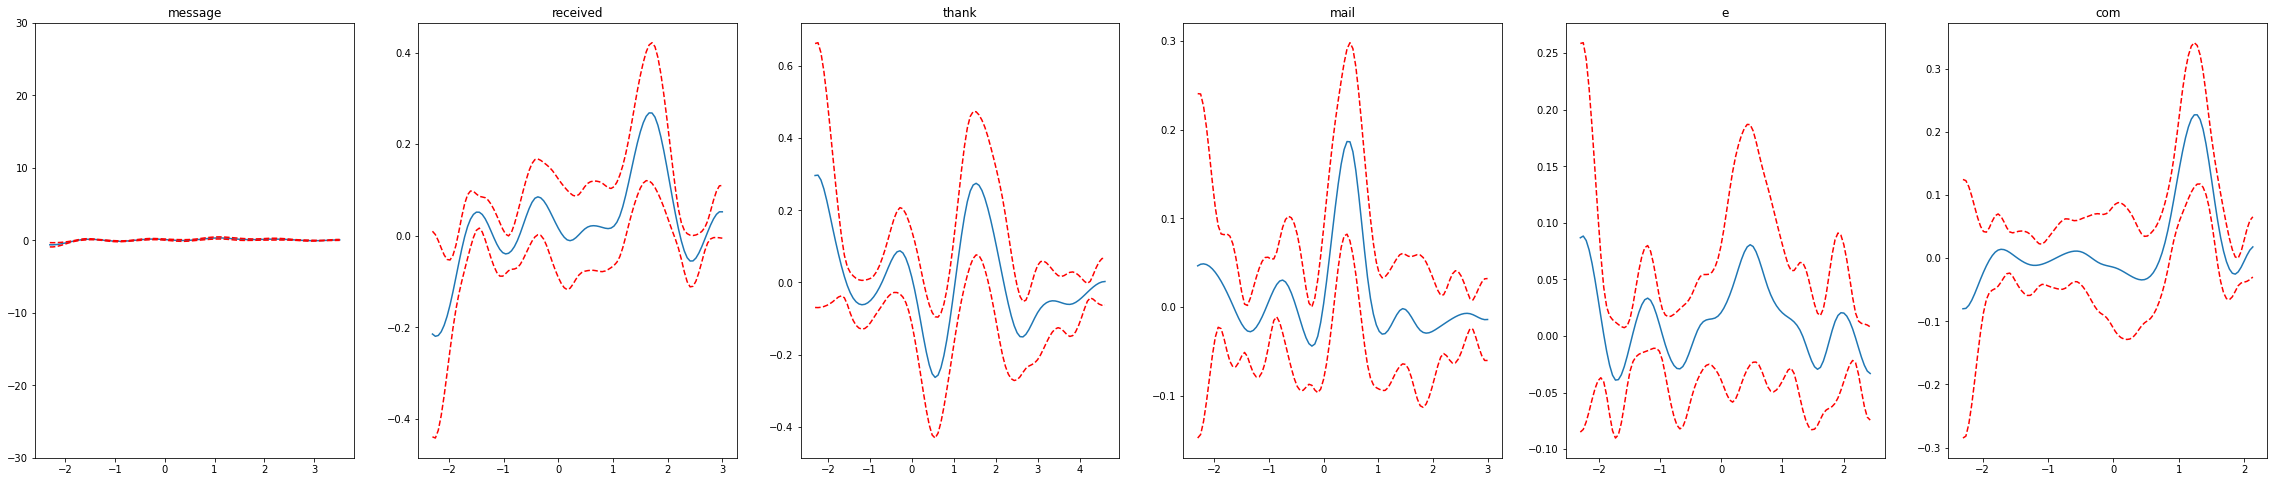

In [89]:
titles = dp.words_indexes[0:6]
titles2 = ['capital_run_length_average', 'capital_run_length_longest', 'capital_run_length_total', 'fragment_length']
plt.figure()
fig, axs = plt.subplots(1,6,figsize=(40, 8))
    
for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
    if i == 0:
        ax.set_ylim(-30,30)
    ax.set_title(titles[i])
    